In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Harold\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Review of sentiment analysis

The sentiment analysis part presents our study of the current best practices of sentiment analysis. From this study, we pick our sentiment analyzer and do some elementary data exploration on the 2017 data.

### Choice of sentiment analyzer

The classic gold standard lexicon, especially for longer text, is LIWC (Linguistic Inquiry and Word Count) [[1]]. It is a Semantic Orientation (Polarity-based) Lexicon. Sociologists, psychologists, linguists, and computer scientists find LIWC appealing because it has been extensively validated. Also, its straightforward dictionary and simple word lists are easily inspected, understood, and extended if desired. Such attributes make LIWC an attractive option to researchers looking for a reliable lexicon to extract emotional or sentiment polarity from text. 

But LIWC is unable to account for differences in the sentiment intensity of words. For example, “The food here is exceptional” conveys more positive intensity than “The food here is okay”. A sentiment analysis tool using LIWC would score them equally (they each contain one positive term). Such distinctions are intuitively valuable for fine-grained sentiment analysis and in our case to detect polarization between two opinions on climate. "I am skeptic about climate" is not as intense as "I hate Greta Thunberg" and we should be able to detect it.

Another aspect to take into account is that a given sentiment analyzer performs differenlty depending on the length of quotes. In our dataset, we have a mixture of short quotes and long quotes with a majority of shorter quotes.

Ease of use such as the need (or not) to train the sentiment analyzer has to be taken into account.

Given all these factors, we have decided  use VADER [[2]] (Valence Aware Dictionary and sEntiment Reasoner). It is pretrained and built into NLTK.

Reading the paper, we know that VADER is best suited for language used in social media and short text. 

VADER is the result of very thorough work. It has been trained on its own valence-aware sentiment lexicon composed of other well established/ "gold standard" sentiment banks such as ANEW (Affective Norms for English Words) [[4]] for sentiment valence ranging from [1-9], LIWC mentioned before and the Genereal Inquirer (GI) [[3]]. On top of that, it incorporates numerous lexical features common to sentiment expression in microblogs.

In the paper, it was shown that VADER (F1 = 0.96) outperforms individual human raters (F1 = 0.84) at correctly classifying the sentiment of tweets into positive, neutral, or negative classes. Furthermore, it was shown to generalize very well and to outperform other analyzers outside of social media text and longer text.


We also went through the ADA lectures on text analysis and remarked that VADER was also used, further convincing us that it is indeed a quality choice.


### Scoring:

Given a sentence, we can use VADER to compute polarity_scores() which will ouptput a dictionary of 4 values ('compound', 'neg', 'neu', 'pos').

 The 'compound' score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of polarity for a given sentence.

The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1 or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.



[2]: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

[3]: http://www.wjh.harvard.edu/~inquirer/

[1]: https://liwc.wpengine.com/

[4]: https://csea.phhp.ufl.edu/media/anewmessage.html

In [132]:
## Setting up a sample dataframe

df = pd.read_pickle("df2017_0")
df['compound'] = df.quotation.apply(lambda x : sia.polarity_scores(x)['compound'])

In [4]:
def analyze_sentiment(text):
    """
    Given text, outputs VADER polarity scores with explanations

    Args:
        text (string)
    """
    sia = SentimentIntensityAnalyzer()
    polarity_scores = sia.polarity_scores(text)
    print(f"Portion of the text which is negative: {polarity_scores['neg']}.")
    print(f"Portion of the text which is neutral: {polarity_scores['neu']}.")
    print(f"Portion of the text which is positive: {polarity_scores['pos']}.")

    print(f"Normalized weighted average valence score of the text: {polarity_scores['compound']}\n")

In [5]:
def plot_sentiment_hist(df,sentiment='compound',all=False):
    """"
    Given the dataframe with quotations, plots the distribution of a given component of polarity_scores() or all components.

    Args:
        df (pd.DataFrame): Dataframe with quotations 
        sentiment (str, optional): Can be 'pos' , 'neg', 'neu' or 'compound'. Defaults to 'compound'. Is ignored if all=True
        all (bool, optional): if true, plot the distribution of all components. Defaults to False.
    """
    
    sia = SentimentIntensityAnalyzer()

    if all:
        f,a = plt.subplots(2,2,figsize=(15,7),sharey=True)
        sentiments = ['neg','neu','pos','compound']
        transformed = df.quotation.apply(lambda x : sia.polarity_scores(x))
        f.suptitle("Distribution of 'neg', 'neu', 'pos' and 'compound' in the given corpus")

        for i, sent in enumerate(sentiments):
            idx = divmod(i,2)
            g = sns.histplot(data=transformed.apply(lambda x: x[sent]), bins='auto',ax=a[idx[0],idx[1]])
            g.set_xlabel(f"{sent} score")
            g.set_yscale('log')
    else:

        transformed = df.quotation.apply(lambda x : sia.polarity_scores(x)[sentiment])
        f, a = plt.subplots(figsize=(15, 5))
        f.suptitle(f"Distribution of {sentiment} sentiment")
        g= sns.histplot(data=test,bins='auto')
        g.set_xlabel(f"{sentiment} score")
        g.set_yscale('log')

In [130]:
def plot_compound_time_series(df, freq = "W"):
    """
    Given a dataframe assumed to have a "compound" column, plots the time series of mutliple aggregates of compound at given frequency (W = week, M = month)

    Args:
        df (pd.DataFrame): dataframe asssumed to have a "compound" column
        freq (str, optional): The frequency of our time series i.e. at frequency do we take our aggregates. Defaults to "W".
    """

    sia = SentimentIntensityAnalyzer()

    ## changing the index into datetime

    new_index = df.reset_index().quoteID.apply(lambda x: x[:10])
    new_df = df.set_index(new_index)
    new_df.index = pd.to_datetime(new_df.index)
    
    mean_compound_values_time_series = new_df.compound.groupby(pd.Grouper(freq=freq)).mean()
    sd_compound_values_time_series = new_df.compound.groupby(pd.Grouper(freq=freq)).std()
    x = range(0,len(mean_compound_values_time_series))

    f, a = plt.subplots(1,2,figsize=(15, 5))
   
    g= sns.lineplot(x=x, y=mean_compound_values_time_series, ax = a[0])
    g.set_title(f"The time series of the mean value 'compound' at frequency {freq}")
    g.set_xlabel(f"Time steps at frequency {freq}")
    g.set_ylabel(f"Mean of compound at frequency {freq}")


    g= sns.lineplot(x=x, y=sd_compound_values_time_series, ax = a[1])
    g.set_title(f"The time series of the standard deviation of the value 'compound' at frequency {freq}")
    g.set_xlabel(f"Time steps at frequency {freq}")
    g.set_ylabel(f"Mean of compound at frequency {freq}")




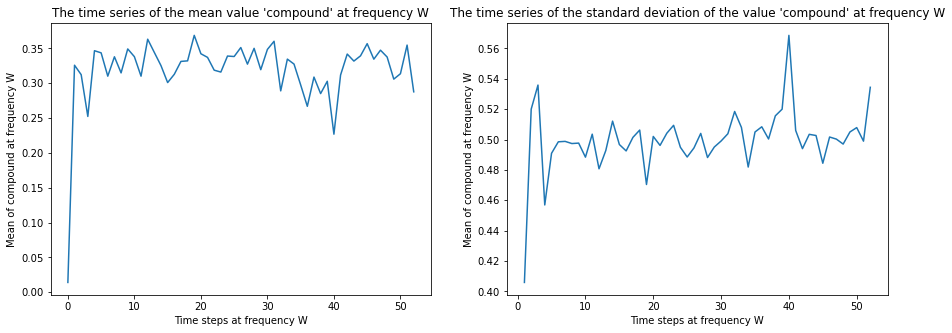

In [131]:
plot_compound_time_series(df)

We can see here that the weekly mean compound score oscillates around 0.3 (meaning slightly positive) but plotting the standard deviation, we can see that there are huge variations around this mean. This is the indicator of our more "polarized" quotes. Investigation into quantizing the compound scores into bins e.g. ([-1, -0.5], [-0.5, 0], [0, 0.5], [0.5, 1] or finer quantization) and looking at most frequent values in these bins should prove to be insightful and let us capture insights about polarization more easily than aggregates.   

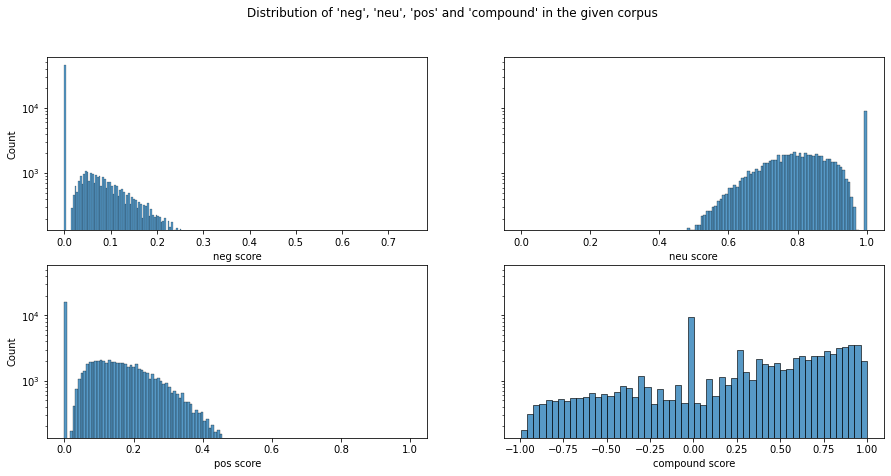

In [6]:
plot_sentiment_hist(df,all=True)

In truly polarized data, we would expect to see a bimodal distribution in the 'compound' distribution. The somewhat uniform distribution of compound might come from two possibilites:

1. The data isn't yet filtered well enough to only capture quotes about climate change
2. Data about climate change isn't polarized enough for us to see a bimodal distribution

Nonetheless, we can see slighlty more mass on the positive side, which is an indicator of more positive quotes in the corpus.